# Pauli Operators with Fire Opal
**Building and measuring Hamiltonians and observables using `PauliOperator`**

Many quantum algorithms are based on the measurement of expectation values described by Pauli operators, such as Ising costs, spin models and chemistry Hamiltonians. Fire Opal’s `PauliOperator` is a compact way to represent these observables as a sparse sum of Pauli strings with complex coefficients. 

In this guide you will learn how to use `PauliOperator` to:

* Construct observables as a single summed operator
* Construct observables as a list of separated operators 
* Calculate expectation values with `estimate_expectation` 
* Map Max-Cut and Heisenberg dimer/XXZ into Pauli terms

## 1. Set up your environment

In [ ]:
import fireopal as fo
from fireopal.types import PauliOperator

import qiskit
from qiskit import qasm3
from qiskit.circuit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService

import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import networkx as nx
from pyscipopt import Model

In [ ]:
# Set credentials
token = "YOUR_IBM_CLOUD_API_KEY"
instance = "YOUR_IBM_CRN"

credentials = fo.credentials.make_credentials_for_ibm_cloud(
    token=token, instance=instance
)

Q-CTRL authentication successful!


## 2. Usage examples
### 2.1 Heisenberg dimer 
The two-qubit Heisenberg dimer is the smallest non-trivial interacting spin system. Despite its size, it captures the essential physics of exchange interactions, anisotropy, and field response that appear in larger spin chains and real materials. The Hamiltonian of the dimer in a longitudinal (Z-axis) magnetic field is given by: 

$$
H \;=\; J_x\,X\!\otimes\!X\;+\;J_y\,Y\!\otimes\!Y\;+\;J_z\,Z\!\otimes\!Z\;+\;h\,(Z\!\otimes\!I + I\!\otimes\!Z).
$$

* The $XX, YY, ZZ$ terms model spin-spin exchange
* The field $h$ biases magnetization along $Z$

In a real workflow you create a parameterized circuit and optimize those parameters against the Hamiltonian. In this example you will implement one iteration of the $XXZ$ Heisenberg dimer with $J_x = J_y = J_\perp$. You choose a small ansatz with hard-coded arbitrary angles, and evaluate the energy via `PauliOperator`.


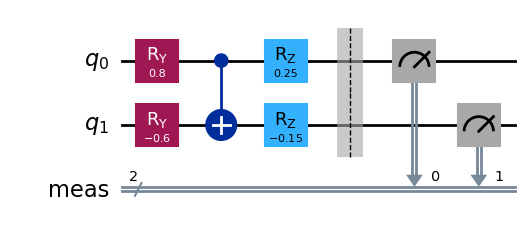

In [41]:
circuit = QuantumCircuit(2)
circuit.ry(0.8, 0)
circuit.ry(-0.6, 1)
circuit.cx(0, 1)
circuit.rz(0.25, 0)
circuit.rz(-0.15, 1)
circuit.measure_all()
circuit.draw(output="mpl", fold=-1)

You will use $J_x=J_y=1.0,\; J_z=0.5,\; h=0.3$, and `PauliOperator.from_list` to obtain the system's Hamiltonian.

In [42]:
Jx, Jy, Jz, h = 1.0, 1.0, 0.5, 0.3

H = PauliOperator.from_list([("XX", Jx), ("YY", Jy), ("ZZ", Jz), ("ZI", h), ("IZ", h)])

In [ ]:
# Define shots and desired backend (replace "desired_backend" with your backend)
shot_count = 1024
backend_name = "desired_backend"

In [ ]:
# Run the circuit with the estimate_expectation function
fire_opal_job = fo.estimate_expectation(
    circuits=[qasm3.dumps(circuit)],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name,
    observables=H,
)
print("Heisenberg dimer energy:", fire_opal_job.result()["expectation_values"])

Heisenberg dimer energy: [0.930859375]


### 2.2 MaxCut on a triangle with per-edge contributions

MaxCut is a classic NP-hard problem and a standard benchmark for quantum algorithms such as QAOA. A full description of its implementation can be found in the application note [Solve Max-Cut using Fire Opal](https://docs.q-ctrl.com/fire-opal/apply/solve-max-cut-using-fire-opal). In general, given a graph $G=(V,E)$, the goal is to partition the vertices into two sets so that the number (or weight) of edges crossing the partition is maximized. In the Ising formulation, each qubit $i$ represents a vertex with spin $z_i \in \{\pm1\}$, and each edge $(i,j)$ contributes a cost

$$
C_{ij} \;=\; \frac{1 - Z_i Z_j}{2},
$$

so the total objective is

$$
C \;=\; \sum_{(i,j)\in E} \frac{1 - Z_i Z_j}{2}.
$$

The only nontrivial measurements are products of $Z$ operators on edge endpoints. Measuring the three $Z_i Z_j$ terms as three separated observables gives you the per-edge contributions; this can reveal parameter settings that overfit some edges while neglecting others. This pattern scales directly to larger, weighted graphs by replacing $Z_i Z_j$ with $w_{ij} Z_i Z_j$ and adjusting the constants accordingly.

In this example, you will calculate one arbitrary iteration of the MaxCut problem for a triangle graph with edges $(0,1), (1,2), (0,2)$, using a traditional QAOA ansatz. 



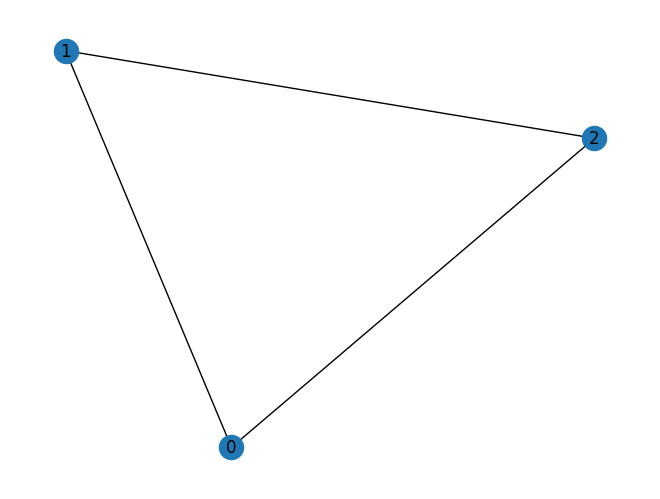

In [ ]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2])
G.add_edges_from([(0, 1), (1, 2), (0, 2)])
nx.draw(G, with_labels=True)
plt.show()

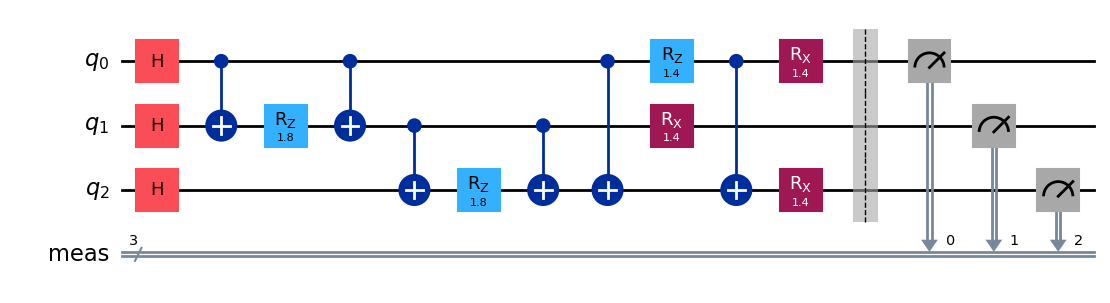

In [ ]:
maxcut_circuit = QuantumCircuit(3)
for i in range(3):
    maxcut_circuit.h(i)
maxcut_circuit.cx(0, 1)
maxcut_circuit.rz(2 * 0.9, 1)
maxcut_circuit.cx(0, 1)
maxcut_circuit.cx(1, 2)
maxcut_circuit.rz(2 * 0.9, 2)
maxcut_circuit.cx(1, 2)
maxcut_circuit.cx(0, 2)
maxcut_circuit.rz(2 * 0.7, 0)
maxcut_circuit.cx(0, 2)
maxcut_circuit.rx(2 * 0.7, 0)
maxcut_circuit.rx(2 * 0.7, 1)
maxcut_circuit.rx(2 * 0.7, 2)
maxcut_circuit.measure_all()

maxcut_circuit.draw(output="mpl", fold=-1)

In [ ]:
edge_terms = [
    PauliOperator("ZZI", -0.5),  # edge (0,1)
    PauliOperator("IZZ", -0.5),  # edge (1,2)
    PauliOperator("ZIZ", -0.5),  # edge (0,2)
]

In [ ]:
fire_opal_job = fo.estimate_expectation(
    circuits=[qasm3.dumps(MaxCut_circuit)],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name,
    observables=edge_terms,
)
print("MaxCut per-edge contributions:", fire_opal_job.result()["expectation_values"])

MaxCut per-edge contributions: [-0.087890625, -0.0068359375, -0.0888671875]


The observables in these examples are constructed using Fire Opal’s `PauliOperator`, which provides a convenient and efficient way to define operations with sparse structure. Fire Opal groups these commuting observables into a single circuit for execution, reducing costs. This notation is especially useful for large qubit systems, as it enables compact and readable definitions of complex multi-qubit operators.

In [27]:
from fireopal import print_package_versions

print_package_versions()

| Package               | Version |
| --------------------- | ------- |
| Python                | 3.12.11 |
| matplotlib            | 3.10.5  |
| networkx              | 2.8.8   |
| numpy                 | 2.3.2   |
| qiskit                | 2.1.1   |
| qiskit-ibm-runtime    | 0.41.0  |
| sympy                 | 1.14.0  |
| fire-opal             | 9.0.1   |
| qctrl-visualizer      | 9.0.0   |
| qctrl-workflow-client | 6.0.0   |
